<a href="https://colab.research.google.com/github/0zeynep/Smart_Home_Energy_Prediction/blob/main/smarthome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
#Veri okuma
df=pd.read_csv('Smart Home Dataset.csv')
df.head()

/tmp/ipython-input-2397426735.py:14: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Smart Home Dataset.csv')


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [2]:
#Veri Temizliği
df = df.dropna() # boşluk olan satırları siler
df['time'] = pd.to_numeric(df['time'], errors='coerce') # Tiem sütunundaki her şeyi sayıya çevirir
df['datetime'] = pd.to_datetime(df['time'], unit='s')#unix time ı okunabilir zamana çevirir
df['hour'] = df['datetime'].dt.hour # saat bilgisini alır


In [3]:
le=LabelEncoder() #Kategorik verileri sayısal değere  çevirir  (0,1,2,3)
df['summary']=le.fit_transform(df['summary'].astype(str))
df['cloudCover']=le.fit_transform(df['cloudCover'].astype(str))

In [4]:
#feture engineering
cihazlar = ['House overall [kW]', 'Dishwasher [kW]', 'Fridge [kW]']
for cihaz in cihazlar:
    column = f'{cihaz}_baseline'
    # 'hour' ve 'summary' (Hava durumu) bazında grupla, cihazın ortalamasını al
    df[column] = df.groupby(['hour', 'summary'])[cihaz].transform('mean')

print(df[['hour', 'summary', 'House overall [kW]', 'House overall [kW]_baseline']].head())

   hour  summary  House overall [kW]  House overall [kW]_baseline
0     5        3            0.932833                     0.937066
1     5        3            0.934333                     0.937066
2     5        3            0.931817                     0.937066
3     5        3            1.022050                     0.937066
4     5        3            1.139400                     0.937066


In [5]:
pivot=df.pivot_table(
    index='hour',
    columns='summary',
    values='House overall [kW]',
    aggfunc='mean')

In [6]:
#Hedef belirleme
features = ['hour', 'summary', 'apparentTemperature', 'humidity', 'visibility',
            'pressure', 'windSpeed', 'cloudCover', 'House overall [kW]_baseline']
target = 'House overall [kW]'
X = df[features]
y = df[target]

In [7]:
#Eğitim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
#KNN Modeli
knn_model = KNeighborsRegressor(n_neighbors=5) # 5 en yakın komşuya bakılır
knn_model.fit(X_train_scaled, y_train)
knn_preds = knn_model.predict(X_test_scaled)


In [10]:
#Random Forest Modeli
rf_model = RandomForestRegressor(n_estimators=25, random_state=42)#100 karar ağacı  olunca çok yavaş çalıştı
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

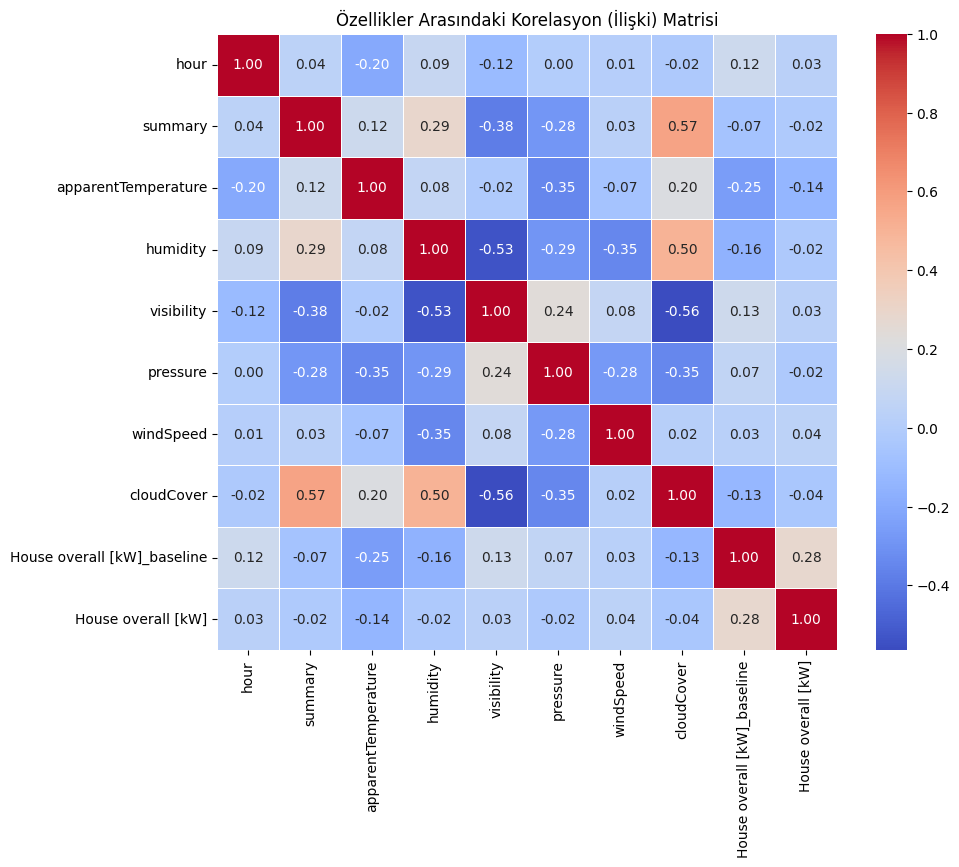

In [11]:
plt.figure(figsize=(10, 8))

numeric_df = df[features + ['House overall [kW]']]
correlation_matrix = numeric_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Özellikler Arasındaki Korelasyon (İlişki) Matrisi')
plt.show()

In [12]:
from sklearn.metrics import r2_score, mean_absolute_error

#KNN
knn_mae = mean_absolute_error(y_test, knn_preds)
knn_r2 = r2_score(y_test, knn_preds)

# Random Forest
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)


print(f"--- KNN PERFORMANSI ---")
print(f"KNN MAE (Hata): {knn_mae:.4f}")
print(f"KNN R2 (Doğruluk): %{knn_r2*100:.2f}")

print(f"\n--- RANDOM FOREST PERFORMANSI ---")
print(f"RF MAE (Hata): {rf_mae:.4f}")
print(f"RF R2 (Doğruluk): %{rf_r2*100:.2f}")

--- KNN PERFORMANSI ---
KNN MAE (Hata): 0.3361
KNN R2 (Doğruluk): %44.58

--- RANDOM FOREST PERFORMANSI ---
RF MAE (Hata): 0.3153
RF R2 (Doğruluk): %52.46
